In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from lmfit.model import Model, save_modelresult, load_modelresult
import math

In [4]:
khydr_modelpath = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/01_ODE_v_analytical/02_eyring_hydrolysis_rate/k_hydr.sav'

lnkhydr_model = load_modelresult(khydr_modelpath)
k_add_mb = (-419.754617, -10.682813)

def calc_kadd_from_eyring(temp, m, b, S):
    """
    Calculate the association rate constant (k_add) from Eyring equation parameters.

    Parameters
    ----------
    temp : float
        Temperature in Kelvin.
    m : float
        Slope of the Eyring plot.
    b : float
        Intercept of the Eyring plot.
    S : float
        Concentration of probe in M.

    Returns
    -------
    float
        Association rate constant (k_add) in units of M^-1 s^-1.
    """

    eyring_y = m * (1 / temp) + b
    return (np.exp(eyring_y) * temp) / S

<>:66: SyntaxWarning: invalid escape sequence '\D'
<>:66: SyntaxWarning: invalid escape sequence '\D'
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_9728/1454864737.py:66: SyntaxWarning: invalid escape sequence '\D'
  axs[2].set_title('±10% $\Delta G$')


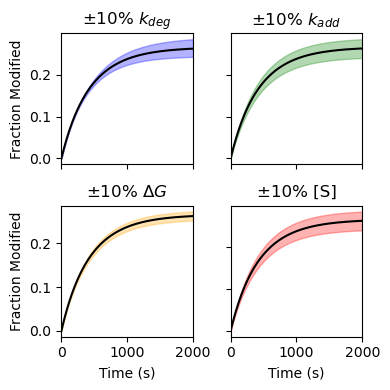

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def pe_model(x, K, k_add, k_deg, S):
    """ Pre-equilibrium assumption model """
    kappa = ((K / (K + 1)) * k_add * S) / k_deg
    return 1 - np.exp(-kappa * (1 - np.exp(-k_deg * x)))

def get_shaded_bounds(x, base_params, param_name, rel_error=0.10):
    """ Return lower and upper bounds on model due to uncertainty in one parameter """
    p_low = base_params.copy()
    p_high = base_params.copy()
    p_low[param_name] *= (1 - rel_error)
    p_high[param_name] *= (1 + rel_error)
    return pe_model(x, **p_low), pe_model(x, **p_high)

# Constants and base parameters
K = 0.5
S = 0.01584
temp_C = 45.0
temp_K = temp_C + 273.15
R = 0.001987  # kcal/mol·K

# Replace with actual expressions or values
k_add_m, k_add_b = k_add_mb  # Define or load these beforehand
k_add = calc_kadd_from_eyring(temp_K, k_add_m, k_add_b, S)
lnk_deg = lnkhydr_model.eval(x=1 / temp_K)  # Replace with actual model
k_deg = np.exp(lnk_deg) * temp_K

base_params = {
    'K': K,
    'k_add': k_add,
    'k_deg': k_deg,
    'S': S
}

x = np.linspace(0, 2000, 200)
y_base = pe_model(x, **base_params)

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(4, 4))
axs = axs.flatten()

# 1. k_deg
y_low, y_high = get_shaded_bounds(x, base_params, 'k_deg')
axs[0].plot(x, y_base, color='black', label='Base')
axs[0].fill_between(x, y_low, y_high, color='blue', alpha=0.3)
axs[0].set_title('±10% $k_{deg}$')

# 2. k_add
y_low, y_high = get_shaded_bounds(x, base_params, 'k_add')
axs[1].plot(x, y_base, color='black', label='Base')
axs[1].fill_between(x, y_low, y_high, color='green', alpha=0.3)
axs[1].set_title('±10% $k_{add}$')

# 3. ΔG (converted to K)
dG = -R * temp_K * np.log(K)
dG_low = dG * 0.90
dG_high = dG * 1.10
K_low = np.exp(-dG_low / (R * temp_K))
K_high = np.exp(-dG_high / (R * temp_K))
y_low = pe_model(x, K_low, k_add, k_deg, S)
y_high = pe_model(x, K_high, k_add, k_deg, S)
axs[2].plot(x, y_base, color='black', label='Base')
axs[2].fill_between(x, y_low, y_high, color='orange', alpha=0.3)
axs[2].set_title('±10% $\Delta G$')

# 4. [S]
y_low, y_high = get_shaded_bounds(x, base_params, 'S')
axs[3].plot(x, y_base, color='black', label='Base')
axs[3].fill_between(x, y_low, y_high, color='red', alpha=0.3)
axs[3].set_title('±10% [S]')

# Formatting
for ax in axs:
    ax.set_xlim(x[0], x[-1])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Fraction Modified')
    ax.label_outer()

plt.tight_layout()
plt.savefig('pe_model_shaded_bounds_1.pdf')
plt.show()

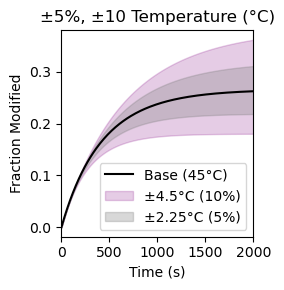

In [27]:
# Create new figure
fig, ax = plt.subplots(figsize=(3, 3))

# Base temperature
T_base_C = 45.0
T_base = T_base_C + 273.15

# Helper function
def compute_bounds(T_low_C, T_high_C):
    T_low = T_low_C + 273.15
    T_high = T_high_C + 273.15

    k_add_low = calc_kadd_from_eyring(T_low, k_add_m, k_add_b, S)
    k_add_high = calc_kadd_from_eyring(T_high, k_add_m, k_add_b, S)

    k_deg_low = np.exp(lnkhydr_model.eval(x=1 / T_low)) * T_low
    k_deg_high = np.exp(lnkhydr_model.eval(x=1 / T_high)) * T_high

    y_low = pe_model(x, K, k_add_low, k_deg_low, S)
    y_high = pe_model(x, K, k_add_high, k_deg_high, S)

    return y_low, y_high

# Compute bounds
y_5_low, y_5_high = compute_bounds(42.75, 47.25)
y_10_low, y_10_high = compute_bounds(40.5, 49.5)

# Plot
ax.plot(x, y_base, color='black', label='Base (45°C)')
ax.fill_between(x, y_10_low, y_10_high, color='purple', alpha=0.2, label='±4.5°C (10%)')
ax.fill_between(x, y_5_low, y_5_high, color='gray', alpha=0.3, label='±2.25°C (5%)')

# Format
ax.set_xlim(x[0], x[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fraction Modified')
ax.set_title('±5%, ±10 Temperature (°C)')
ax.legend()
plt.tight_layout()
plt.savefig('pe_model_shaded_bounds_2.pdf')
plt.show()